In [81]:
import pandas as pd
import numpy as np
from kiteconnect import KiteConnect, KiteTicker
import login
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import pytz
import pymongo
import threading
import os

In [82]:
# Access environment variables
user_name = os.getenv("KITE_USER_NAME")
password = os.getenv("KITE_PASSWORD")
totp = os.getenv("KITE_TOTP")
api_key = os.getenv("KITE_API_KEY")
api_secret = os.getenv("KITE_API_SECRET")

kite = KiteConnect(api_key=api_key)
request_token = login.kiteLogin(user_name, password, totp, api_key)
data = kite.generate_session(request_token, api_secret)
kite.set_access_token(data["access_token"])

In [83]:
instrument_dump = kite.instruments()   # get instruments dump from NSE
instrument_df = pd.DataFrame(instrument_dump)  # dump it to a dataframe
print(instrument_df.columns)

Index(['instrument_token', 'exchange_token', 'tradingsymbol', 'name',
       'last_price', 'expiry', 'strike', 'tick_size', 'lot_size',
       'instrument_type', 'segment', 'exchange'],
      dtype='object')


In [84]:
def getInstrumentToken(symbol):
    #return none if not found
    if len(instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values)==0:
        return None
    return instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values[0]

In [85]:
#get the list of finserv stocks from instrument dump
bse_stocks=pd.read_csv('bse.csv')
#keep only Financial Services stocks
bse_stocks=bse_stocks[bse_stocks['Sector Name']=='Financial Services']
#reset the index
bse_stocks.reset_index(drop=True,inplace=True)

token_list=[]
#get the security id and check if it is present in the instrument dump with exchange as NSE
for index, row in bse_stocks.iterrows():
    symbol=row['Security Id']
    print(symbol)
    token=getInstrumentToken(symbol)
    print(token)
    if token:
        print(symbol,token)
        token_list.append(token)
    else:
        print('Token not found for symbol:',symbol)
        #remove the row from the dataframe
        bse_stocks.drop(index,inplace=True)

#add token list to the dataframe
bse_stocks['Token']=token_list
#remove if Industry == Mutual Fund Scheme - ETF
final_env=bse_stocks[bse_stocks['Industry']!='Mutual Fund Scheme - ETF']
#reset the index
final_env.reset_index(drop=True,inplace=True)
#set the index to 'Security Id'
final_env.set_index('Security Id',inplace=True)
#first sort accourding to 'Security Id' and then 'Industry'
final_env.sort_values(by=['Industry','Security Id'],inplace=True)
print(final_env)

BAJFINANCE
81153
BAJFINANCE 81153
QUESTCAP
None
Token not found for symbol: QUESTCAP
CRISIL
193793
CRISIL 193793
IFCI
381697
IFCI 381697
SBIN
779521
SBIN 779521
IDBI
377857
IDBI 377857
FGP
None
Token not found for symbol: FGP
PHCAP
None
Token not found for symbol: PHCAP
GFLLIMITED
None
Token not found for symbol: GFLLIMITED
GLFL
None
Token not found for symbol: GLFL
HDFCBANK
341249
HDFCBANK 341249
NDLVENTURE
3724033
NDLVENTURE 3724033
INDLEASE
None
Token not found for symbol: INDLEASE
MARGOFIN
None
Token not found for symbol: MARGOFIN
KOTAKBANK
492033
KOTAKBANK 492033
LICHSGFIN
511233
LICHSGFIN 511233
HYBRIDFIN
None
Token not found for symbol: HYBRIDFIN
MAHSCOOTER
None
Token not found for symbol: MAHSCOOTER
MFSL
548353
MFSL 548353
PEL
617473
PEL 617473
PRIMESECU
3037185
PRIMESECU 3037185
VHL
3044353
VHL 3044353
MPILCORPL
None
Token not found for symbol: MPILCORPL
FEDERALBNK
261889
FEDERALBNK 261889
BAJAJHLDNG
78081
BAJAJHLDNG 78081
SUNRINV
None
Token not found for symbol: SUNRINV
DSINV

C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2155531653.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env.sort_values(by=['Industry','Security Id'],inplace=True)


In [86]:
def calculate_moment_score(df):
    if len(df) < 2:
        return np.nan
    # Get the pct change from the first to the last value
    pct_change = (df['close'].iloc[-1] / df['close'].iloc[0] - 1)
    # Get the std of pct change
    pct_change_std = np.std(df['close'].pct_change())
    if pct_change_std == 0:
        return np.nan
    score_value = pct_change / pct_change_std
    return score_value


#fuction to get zscore accourding to each column
def get_zscore(df):
    for column in df.columns:
        # print(df[column])
        df[column] = (df[column] - df[column].mean())/df[column].std()
    return df
    

def get_moment_score(df,date):
        moment_dict = {}
        # print(df.head(10))
        symbollist = df.index.to_list()
        # print(symbollist)
        end_date = datetime.strptime(date, '%Y-%m-%d')
        start_date = end_date - relativedelta(months=6)
        start_date = start_date.strftime('%Y-%m-%d')

        for symbol in symbollist:
            # print(symbol)

            try:
                stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
                #make dataframe of the stock data
                stock_data = pd.DataFrame(stock_data)
                data_points = len(stock_data)
                three_month = stock_data.tail(data_points//2)
                data_points = len(three_month)
                one_month = three_month.tail(data_points//3)
                data_points = len(one_month)
                two_week = one_month.tail(data_points//2)
                data_points = len(two_week)
                one_week = stock_data.tail(5)
                three_days = stock_data.tail(3) 


                socre_t = calculate_moment_score(stock_data)
                score_3m = calculate_moment_score(three_month)
                score_1m = calculate_moment_score(one_month)
                score_2w = calculate_moment_score(two_week)
                score_1w = calculate_moment_score(one_week)
                score_3d = calculate_moment_score(three_days)

                # print(socre_t,score_3m,score_1m,score_2w,score_1w,score_3d)

                row={'score_t':socre_t,'score_3m':score_3m,'score_1m':score_1m,'score_2w':score_2w,'score_1w':score_1w,'score_3d':score_3d}
                moment_dict[symbol] = row

            except:
                # print("Error in getting data for symbol: ", symbol)
                moment_dict[symbol] = {"Z_score_t": np.nan, "Z_score_3m": np.nan, "Z_score_1m": np.nan, "Z_score_2w": np.nan, "Z_score_1w": np.nan, "Z_score_3d": np.nan}

        moment_score_results = pd.DataFrame(moment_dict).T
        # print(moment_score_results)
        moment_score_results = get_zscore(moment_score_results)
        return moment_score_results
        # df['Moment Score'] = moment_score_results['Moment_score']

        # return df

# get the moment score for the stocks
date='2024-01-08'
moment_score_df = get_moment_score(final_env,date)

In [87]:
final_env['Industry']=final_env['Industry'].str.strip()
final_env['Igroup Name']=final_env['Igroup Name'].str.strip()
moment_score_df['Industry']=final_env['Industry']
moment_score_df['Igroup Name']=final_env['Igroup Name']
print(moment_score_df)


             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
ABSLAMC     0.638894  0.053595 -0.142549 -0.018980  0.079471  0.094883   
HDFCAMC     1.266368  1.357632  2.393767  0.219844  0.262090  0.113345   
IVC        -0.095708  0.655515  0.431155  0.024462 -0.261702  0.153922   
NAM-INDIA   1.637225  1.476182  0.445489  0.140156 -0.108438  0.086463   
UTIAMC     -0.498275  0.254335  0.287563  0.254184  0.160529  0.047315   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  1.270330  1.272348  0.738762  0.133478  1.164877  0.302134   
NUVAMA     -0.203966 -0.177699 -1.180680 -0.091137 -0.477336  0.049256   
ONELIFECAP -0.374812 -0.810417 -2.145724 -0.052284 -0.384558 -0.009702   
SHAREINDIA  0.760685  1.144802 -0.058873 -0.002390 -0.377452  0.045361   
SMCGLOBAL   0.443554  0.682317 -1.146651  0.047151 -0.140771  0.086444   

                            Industry      Igroup Name  
ABSLAMC     Asset Management Company  Capital Markets  

C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2049701812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env['Industry']=final_env['Industry'].str.strip()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2049701812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_env['Igroup Name']=final_env['Igroup Name'].str.strip()


In [88]:
#calulate beta for each stock
def get_beta(stock_df, market_df):
    try:
        stock_df['Close'] = stock_df['close']
        stock_df['Returns'] = stock_df['Close'].pct_change()

        market_df['Close'] = market_df['close']
        market_df['Market Returns'] = market_df['Close'].pct_change()

        stock_df = stock_df.dropna()
        stock_df = stock_df.reset_index(drop=True)

        market_df = market_df.dropna()
        market_df = market_df.reset_index(drop=True)

        beta = np.cov(stock_df['Returns'], market_df['Market Returns'])[0][1] / np.var(market_df['Market Returns'])
    except:
        beta = np.nan
    print(beta)
    return beta

def calculate_returns(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].iloc[-1] / stock_df['close'].iloc[0] - 1
    return stock_return

def calculate_expected_returns(beta,market_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    return expected_return

def calculate_risk_std(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].pct_change()
    stock_return_std = np.std(stock_return)
    return stock_return_std


def get_beta_score(df,date):
        
    # print(df.head(10))
    symbollist = df.index.to_list()
    # print(symbollist)
    end_date = datetime.strptime(date, '%Y-%m-%d')
    start_date = end_date - relativedelta(years=1)
    start_date = start_date.strftime('%Y-%m-%d')

    beta_dict={}
    i=0

    one_year_market_data = kite.historical_data(getInstrumentToken('NIFTY 50'), start_date, end_date, "day")
    #make dataframe of the stock data
    one_year_market_data = pd.DataFrame(one_year_market_data)
    data_points = len(one_year_market_data)
    six_month_market_data = one_year_market_data.tail(data_points//2)
    data_points = len(six_month_market_data)
    three_month_market_data = six_month_market_data.tail(data_points//2)
    data_points = len(three_month_market_data)
    one_month_market_data = three_month_market_data.tail(data_points//3)
    data_points = len(one_month_market_data)
    two_week_market_data = one_month_market_data.tail(data_points//2)
    data_points = len(two_week_market_data)
    one_week_market_data = one_month_market_data.tail(5)

    #calulate returns for each time period
    market_return_1y=calculate_returns(one_year_market_data)
    market_return_6m=calculate_returns(six_month_market_data)
    market_return_3m=calculate_returns(three_month_market_data)
    market_return_1m=calculate_returns(one_month_market_data)
    market_return_2w=calculate_returns(two_week_market_data)
    market_return_1w=calculate_returns(one_week_market_data)    

    market_returns={'market_return_1y':market_return_1y,'market_return_6m':market_return_6m,'market_return_3m':market_return_3m,'market_return_1m':market_return_1m,'market_return_2w':market_return_2w,'market_return_1w':market_return_1w}    

    data_points = len(one_year_market_data)
    for symbol in symbollist:
        print(symbol)
        one_year_stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
        #make dataframe of the stock data
        one_year_stock_data = pd.DataFrame(one_year_stock_data)
        data_points = len(one_year_stock_data)



        #6 month data
        six_month_stock_data = one_year_stock_data.tail(data_points//2)
        # data_points = len(six_month_stock_data)
        six_month_market_data = one_year_market_data.tail(data_points//2)
        data_points = len(six_month_market_data)
        #reset the index
        six_month_stock_data.reset_index(drop=True,inplace=True)
        six_month_market_data.reset_index(drop=True,inplace=True)

        #3 month data
        three_month_stock_data = six_month_stock_data.tail(data_points//2)
        # data_points = len(three_month_stock_data)
        three_month_market_data = six_month_market_data.tail(data_points//2)
        data_points = len(three_month_market_data)

        #1 month data
        one_month_stock_data = three_month_stock_data.tail(data_points//3)
        # data_points = len(one_month_stock_data)
        one_month_market_data = three_month_market_data.tail(data_points//3)
        data_points = len(one_month_market_data)

        #2 week data
        two_week_stock_data = one_month_stock_data.tail(data_points//2)
        # data_points = len(two_week_stock_data)
        two_week_market_data = one_month_market_data.tail(data_points//2)
        data_points = len(two_week_market_data)

        #1 week data
        one_week_stock_data = one_month_stock_data.tail(5)
        # data_points = len(one_week_stock_data)
        one_week_market_data = one_month_market_data.tail(5)
        data_points = len(one_week_market_data)

        one_year_beta=get_beta(one_year_stock_data,one_year_market_data)
        six_month_beta=get_beta(six_month_stock_data,six_month_market_data)
        three_month_beta=get_beta(three_month_stock_data,three_month_market_data)
        one_month_beta=get_beta(one_month_stock_data,one_month_market_data)
        two_week_beta=get_beta(two_week_stock_data,two_week_market_data)
        one_week_beta=get_beta(one_week_stock_data,one_week_market_data)

        #calculate returns for each time period
        stock_return_1y=calculate_returns(one_year_stock_data)
        stock_return_6m=calculate_returns(six_month_stock_data)
        stock_return_3m=calculate_returns(three_month_stock_data)
        stock_return_1m=calculate_returns(one_month_stock_data)
        stock_return_2w=calculate_returns(two_week_stock_data)
        stock_return_1w=calculate_returns(one_week_stock_data)

        #calulate expected returns
        expected_return_1y=calculate_expected_returns(one_year_beta,market_return_1y)
        expected_return_6m=calculate_expected_returns(six_month_beta,market_return_6m)
        expected_return_3m=calculate_expected_returns(three_month_beta,market_return_3m)
        expected_return_1m=calculate_expected_returns(one_month_beta,market_return_1m)
        expected_return_2w=calculate_expected_returns(two_week_beta,market_return_2w)
        expected_return_1w=calculate_expected_returns(one_week_beta,market_return_1w)

        risk=calculate_risk_std(three_month_stock_data)


        row={'beta_1y':one_year_beta,'beta_6m':six_month_beta,'beta_3m':three_month_beta,'beta_1m':one_month_beta,'beta_2w':two_week_beta,'beta_1w':one_week_beta,
             'stock_return_1y':stock_return_1y,'stock_return_6m':stock_return_6m,'stock_return_3m':stock_return_3m,'stock_return_1m':stock_return_1m,'stock_return_2w':stock_return_2w,'stock_return_1w':stock_return_1w,
             'expected_return_1y':expected_return_1y,'expected_return_6m':expected_return_6m,'expected_return_3m':expected_return_3m,'expected_return_1m':expected_return_1m,'expected_return_2w':expected_return_2w,'expected_return_1w':expected_return_1w,'risk':risk}
        beta_dict[symbol] = row

    beta_df=pd.DataFrame(beta_dict).T
    print(beta_df)
    return beta_df,market_returns
date='2024-01-08'
beta_score_df,market_return=get_beta_score(final_env,date)

ABSLAMC
0.33588573899733065
0.09051665850643073
0.029043262489664008
-0.11645403592147191
0.44570255461474556
1.0461606681366984
HDFCAMC
1.1102953195764873
0.8989974266391233
0.5436740624839559
0.15770670203355866
0.31226196083754576
1.069486680248281
IVC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.0981245999080829
1.7185333250896817
2.514360501721752
5.005356991604849
0.2067519124036936
0.9120362251361549
NAM-INDIA
0.7866035902335534
0.5280161532023555
0.5333537854696664
-0.719126649918062
0.6389208839655939
4.199203723718585
UTIAMC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9398869444154183
0.9594875565251141
0.8699492076831297
0.7358312731134672
0.4680156864612479
0.7206996453565627
CAMS
0.6696101917183983
0.9391924709791359
1.0623920708524877
0.4071866335296257
0.5091534707869795
1.8201067611920594
KFINTECH


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6940228796409188
0.40336043500106594
0.939003090953569
1.3127937396343776
-0.18394016052749892
0.807995902292917
IEX
0.908469561975766
1.3412769512402527
1.4187784988552652
1.9049444631891217
1.6330256949804276
2.6637629689698525
MCX


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6701481971866055
0.6300202735241553
0.5722014782448388
0.689719370614569
0.1332001337910851
-0.6021935115743579
HUDCO
1.348747764742205
1.701094259927894
2.6119418886250285
4.607641952490729
6.483233693179348
2.438465420138741
IFCI


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2058464789299947
1.1879481080398515
2.165992392931659
1.9677709102345833
0.0840639906579909
0.4139341163700363
IREDA
nan
1.5662528665123827
3.205646021237938
nan
nan
nan
IRFC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2909888284041555
2.0445460429778137
1.800544911396765
3.1294489934514425
-0.4109038173344653
0.18327260903313905
PFC
1.553766148511871
1.2260976510026835
1.3179416770136112
0.8899654768238862
-0.0826063221987328


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3796792273000864
RECLTD
1.1735401098478528
0.9462963376733241
1.4754873309532115
0.8335485564612211
-0.2501231604503766
1.3459980789361192
TFCILTD


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2700459847478558
1.3099100540812585
0.7798190617329945
0.5746969476799975
-0.9477790695980666
-0.890599296177269
ANANDRATHI
-0.022244393079263042
-0.2990470312740236
0.13003893521734425
0.42915236018025066
-1.2256339100989349
0.5790087240696046
PRUDENT


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6659289930858564
1.0390272931721172
1.141817196993836
1.6754189340629964
2.2125383790870745
4.002342073689958
AGSTRA
1.1045984079907147
1.0004741995462334
1.4691898351951616
1.292263226530716
-1.3016692560927023
-3.559626993866915
INFIBEAM


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2184974820717858
1.7980525921464778
1.3665988003043903
1.5700978846600844
-0.10248202303928107
1.420399102004348
PAYTM
1.0891980225318558
1.1863739937433426
0.8254298124538434
0.36834304151668484
-1.0923365665015075
-1.5573935319804688
POLICYBZR


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6726109487462497
0.8825988677009435
0.8057072893144533
0.9061906406854374
-0.39336190805533117
0.02088047370610007
SUVIDHAA
1.041822001532159


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2769859869196798
1.6898802139991793
2.5553744309536306
2.7458818977335695
-0.2901688387872236
GICRE
1.1915147242192357
0.7566321629804976
0.5540974478742968
1.5102482772708368
1.0272666677800628
1.478876272148813
GODIGIT
nan
nan
nan
nan
nan
nan
ICICIGI
0.7028057266548701
0.7694811912613854
0.5227421567480794
0.8398499178805758
1.5070206943495028
1.9800232513898288
NIACL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2325377686520818
0.99356255357644
0.9749554901195279
0.5949435623490801
1.8209987907205778
3.9563977747652834
STARHEALTH
0.3455313348391962
0.5569150535743079
0.3756473137520138
0.6350473278067351
0.3131382117614413
0.10403449117593437
AHL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.4128919743400326
1.1516690054205758
0.9532632500717092
0.7299228539659949
1.4213662560027238
2.8148400938029043
BAJAJFINSV
1.0762800667435648
0.8392136385360266
0.8284584271538784
0.9838930043323166
1.2261389134859888
1.7710862392202873
BAJAJHLDNG


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.37773564000384136
0.45998084803116507
0.4759751423301407
-0.9302025811718032
-1.074663977779353
-1.0524925612802838
BFINVEST
0.6199010562453364
0.5331779559631824
1.0476300769501976
0.8961786411783419
0.3306547213722755
3.410268371111915
CHOICEIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.46225802930370385
0.5989794426553884
0.493383774464333
-0.08307274762683313
0.16005415009537385
-0.8262483842939389
EDELWEISS
0.9490260891362304


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9712921072821807
1.031808121156435
0.6448650622558663
1.380260719798709
1.8447644848003353
JMFINANCIL
1.0591192418168673
1.4134405699781682
2.0778335509035606
3.8108006965583145
1.6038845287514725
1.8898830011268493
MAXIND
0.8348587396981171
0.8564610815211573
0.642743038534798
-0.43774224191099087
-3.094403424000755
-5.5909333131240455
RANEHOLDIN
0.721983138090782
0.573663880083985
0.6289610864057095
0.8842257011582111
0.3603827754212087
0.6743802880889859
AADHARHFC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
nan
nan
nan
nan
nan
AAVAS
0.041594781640489804
-0.00340812431701476
0.3043281578084035
0.19595781233436121
0.8920566079514222
0.7520191066269669
APTUS


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.676630902064906
0.8012764070250157
1.0280627937313322
0.2375247597821656
0.4094876696207765
2.6914125534913755
CANFINHOME
1.123781272658957
1.1800046015499461
1.201309715290998
1.163048021774218
1.2306639329952846
2.3232917899815715
GICHSGFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3534136237803058
1.1925124638193065
1.1545297837017208
1.967770385106596
1.3243325938217878
2.729182721287967
HOMEFIRST
0.5187570020190189
0.5622795358485434
0.8705050229548439
0.7097937823540212
-0.29083369616673743
0.2664486629198682
INDIASHLTR
nan
-0.5937238366458064
0.2879511041738347
nan
nan
nan
LICHSGFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3558389131951072
1.3536928810723667
1.3879902582884605
1.4883286863422662
2.127485131488832
3.3586625532463628
PNBHOUSING
0.9186877758872866
0.856804655482558
0.9639663052132109
0.9729880211343968
0.32780272246056474
1.2524655889789515
REPCOHOME


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.1805914576126721
1.0604813453445219
0.8350101479794592
1.5430936098185517
0.22109412598706074
1.1350031729504826
SRGHFL
nan
1.0931136766160945
2.1928006783617704
-1.1712376806141442
-1.623910228705684
-1.337864466139515
MEDIASSIST
nan
nan
nan
nan
nan
nan
ABCAPITAL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3838061312004026
1.2550762306459893
1.126362925857057
1.0838248964711343
0.21796492438790535
1.5819444791222879
BLBLIMITED
0.43461624053924963
1.036402644935179
0.9733267750977985
1.4357106982820964
-0.5092402699231301
0.3952797331439675
CHOLAHLDNG


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9118236774347774
1.0436658515552955
1.1473251923747816
1.43845125491674
0.8415825570498698
2.4467242553113318
DHUNINV
1.1262702721758173
1.0327432358355064
1.3597200726069039
1.091421116125282
0.31185909826298475
1.910899847229482
HEXATRADEX


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.3933725699295222
1.0377276768765504
1.1676969516753595
1.6762804972745806
-0.3352462689801077
-0.5621122516727404
JPOLYINVST


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.7300549916128891
0.8423280533478097
0.8577195465749169
1.3732754556205504
0.7046629624279667
2.0063386436103543
JSWHL
0.5250118208274288
0.5234916319297747
0.3869676540197276
0.6019446559499559
0.2011376599893617
0.4939800514339291
LTF


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.5752602060319876
1.7916426338365943
1.8352800294755083
2.2434471467441135
1.8786561258263335
1.9687373644447916
NAGREEKCAP
nan
-0.23848422029766472
-0.8576650872747102
-0.2174890978777209
-0.3093501761924618
1.9076603357378916
NAHARCAP


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.973972348579731
1.1745609043779148
0.7297905101074486
0.2554256343559454
0.0804349581377476
0.2590613060570662
OSWALGREEN
1.121077333229703
0.8418236105410333
1.2116885746089046
1.4392702331215566
2.684139821764172
8.064641858635035
PNBGILTS


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2096960086823665
1.7752113201758348
1.8811130245375245
1.8835669684114573
1.4168241419454526
1.6035780262516104
RELIGARE
0.5652579388711144
0.5803658860630195
0.18399038908809437
0.8853100881165795
1.2208340355375695
3.7796172792173954
SCILAL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
nan
nan
nan
nan
nan
TATAINVEST
0.5063298662499472
0.3151743472671517
0.5166311448538444
1.2003647704447535
0.1415394055791529
-0.12296142845535388
VLSFINANCE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.49077550870852693
1.1139347515639972
1.3138330004419774
2.1775819692659546
0.6575649015285031
2.1780945626323884
WELINV
0.37888794987306085
-0.1138072985670887
0.12737426695772947
0.9729358829652256
-0.5811451051428101
0.20887929457089024
WILLAMAGOR


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.5141830120011954
0.2135533539461238
-0.22678601004978258
-1.695285230724058
1.7861577028496076
2.278752618773667
WORTH
0.845398152231393
0.659229081315899
0.37635397760300604
0.10225574998411721
-1.4631568108876598
-0.14543598299101684
HDFCLIFE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8469295532010961
0.49856293867156676
0.33018019186642356
0.14949550505555737
1.2209114008361457
1.667474205559895
ICICIPRULI
0.8261926543205146
0.5229075137698154
0.41847828278997745
-0.20383310106768457
0.2700470453938358
0.54457648247442
LICI


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8808190365643557
0.9826802012732889
1.2762685924538617
1.3891702055336408
2.8460862861484597
1.4695346925973818
MFSL
1.020551493794075
0.8361688152482127
0.8798452523950376
0.32045696158518383
2.583314667523098
3.0380630094214136
SBILIFE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9457286042600282
0.8784491204859094
0.7025843538535309
0.6017486655285166
2.0074432438548695
2.705755741086828
CREDITACC
0.17776721085033234
0.12051790985892688
-0.5205540023830059
-0.38934709431482695
0.21744871256176448
2.8472652696423983
FUSION


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8501065933755633
0.9254628402880999
1.3422506623999126
1.956033776868644
0.7219392396606398
3.5278370199252724
MUTHOOTMF
nan
0.40045443964548816
nan
nan
nan
nan
SATIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.216327559964477
0.9565341133285722
1.0045723502907404
1.2017441303305223
0.06118706166453577
2.5768808664406286
SPANDANA
1.0560019110344188
1.0783200798928696
1.3302147881849125
1.545128676938004
0.15838998456607523
0.29738948308769003
AFIL
nan
nan
nan
nan
nan
nan
AIIL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
nan
nan
nan
nan
nan
ARMANFIN
0.30027009075727384
0.5033884993194415
0.4965371649493941
1.0514279199363465
0.7971063843500152
1.2987531712049616
AVONMORE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.7397596807733956
0.8634782904381738
0.7308667340086201
0.16469431784529165
0.3739914756741495
3.4345653314196043
BAJFINANCE
1.0458487358446564
0.8681016771509656
0.9975815857050191
0.8335120667194765
1.039998607853937
2.9714064605615635
CGCL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.07598045694428487
0.0756135080830919
-0.46623275935071373
-1.4993267012789104
-4.5474861204330725
-8.874568617571319
CHOLAFIN
0.9655730984884503
1.071457626989291
1.16559239441189
1.136019755134763
0.8683466725360738
2.5997327545306237
CREST


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9238086072050714
0.9349141055730091
0.9392464629703262
2.373155960083177
1.018735566808084
4.1559841192810785
CSLFINANCE
1.0765353040985235
1.2604453436178624
1.8878483988134673
4.040329323054387
1.1753053221262222
2.209386825221782
FEDFINA


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
0.5598266902176238
1.3434376572150133
nan
nan
nan
FIVESTAR
0.7561404722570945
0.7440026544004537
1.1780730658364245
1.6528280867234246
1.7214954709033705
1.460453858226225
HBSL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.5594198881998741
0.38989420652676887
-0.18368830095818578
-0.37903737953591665
-0.4589225799581574
0.3770004258563825
IIFL
0.8359565033026624
0.8720960412077133
1.10101379498236
1.1129033438333311
2.124797044123496
5.8205299537303965
INDOSTAR


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.504352792101497
0.4768801283449769
0.5926489948547093
0.6131280698823873
0.01713267234082861
-0.7592419049350122
JIOFIN
nan
0.8097920229100934
0.69755030719452
2.3303617402828167
3.0009759827622324
2.7165135742133866
M&MFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.265830619548232
1.1645793641336963
1.0832262967103448
1.7528864110919633
0.6891262910466701
0.634860734559299
MANAPPURAM


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.4313535669943154
1.4359856419616592
1.9169012379389685
1.4597434677172767
-0.9395836934926185
-1.7688275902674866
MANCREDIT
nan
nan
nan
nan
nan
nan
MASFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.5091252726139829
0.4526024950467131
0.4152851212057661
0.38949182059671905
-1.6109901422670077
-1.3811868393450693
MUFIN
nan
-0.40044709125648104
-1.4451317413627736
-0.030492849141320617
nan
-0.030492849141320617
MUTHOOTCAP


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6850908377677449
0.44373565690644684
0.08295882775643518
0.0011917763622368602
-2.2956927602165873
-0.9178241886594117
MUTHOOTFIN
0.8337173474124189
1.0788614196109167
0.8307712308588683
1.1455855515412943
1.3627896003463298
1.3039883372124388
PAISALO


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.1608740690853916
1.2706643568039084
1.1443069552864245
0.03449445642888956
-0.6992708625705789
1.0708667428140273
PEL
1.6690939357059118
1.6976039421321232
1.9351343598846382
2.7776240346202044
0.9824851918712187
1.5510000911269464
PFS


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2315105771229258
1.6264612223775565
2.235159502984523
3.0765959397868596
1.2406236758027436
2.060179895178131
POONAWALLA
1.0011315127469287
0.7875034078706428
1.1601427898952599
1.0071020805952036
0.5304976992320518
3.5440346122442414
SBFC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
0.16068469868680404
0.7646789922307228
-1.3377219170940695
0.2531993216573148
-1.699481037471468
SBICARD
0.8127278992482528
0.869595268447849
0.7176088072684141
0.8538381038601821
-0.06643759639857844
0.5623249197071343
SHRIRAMFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8859470335829446
1.1484551828146392
1.4745883211482265
1.2266345735863837
-0.14790256210018818
0.3673479229375774
STARTECK
nan
1.023649683912163
1.6213584187979728
3.060317382227013
-2.2670532436911124
-0.3388944444091953
SUMMITSEC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8328122623798248
0.7760809862829924
0.5055033936684621
1.2834942321600806
1.005021734272396
3.545940857605783
SUNDARMFIN
0.4323391901163363
0.580385194290385
0.8167453362519731
0.6280263287920187
-0.897078292047557
-2.3032629140461793
TIMESGTY


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.41231115609581864
-0.1905422259808705
-0.8278426894038018
0.301792703046041
-2.836001921222831
-1.626199214218201
UGROCAP
0.9448354190689031
0.9975059181127677
0.5775788589915489
1.1326052276183234
1.0539994665816022
3.0014159324454797
UYFINCORP


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
nan
nan
nan
nan
nan
VHL
0.5460279667481931
0.6137871277710859
0.4616907598224603
0.9190794932951241
1.1538497380800357
4.824248056374252
VIJIFIN


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.7293611172940897
0.4130749291188713
0.309457485399029
1.559677293027516
-0.5968732048549062
1.1434943286824557
AUBANK
0.7515570516034045
0.35704708225547416
0.29075360857762067
0.24128487512954294
1.5271973508212142
2.250883633290118
CAPITALSFB


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
nan
nan
nan
nan
nan
EQUITASBNK
0.6583684075308012
0.6702027620407933
0.7506235207445798


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.062161543086585
1.5123169259841027
2.5866941416339553
ESAFSFB
nan
2.0783044492441833
0.2113799294991876
-2.1043936126183644
nan
-2.1043936126183644
FINOPB
0.8682166230589567
0.6802538340506964
0.6020702309557243
0.7277805379742475
1.2818921198582243
3.6861271517261276
JSFB
nan
nan
nan
nan
nan
nan
SURYODAY


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9067887093061139
1.1309163367015587
1.0926328166284134
1.6727817697480913
0.778003529307771
2.6925193928724065
UJJIVANSFB
0.8538593997562072
0.7684983980278344
1.3022432725980766
1.5505827574346143
0.6977629514169005
2.3525312665887355
UTKARSHBNK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

nan
1.0287300148280638
0.8274485089367553
4.7007737282312725
9.74635615153623
7.574459006028653
CENTRUM
0.6825786578163815
1.0280768416434243
1.0188641003265324
0.4448637379657878
-3.4298286410127106
-4.613747649288048
CRISIL


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.3744673009775701
0.5522865976759073
0.6941001050268432
0.722413267639849
-0.018960415376758275
1.131300230153497
DELPHIFX
0.491676009898117
1.1706385920234224
1.2980908989969793
2.249415156116503
-1.3641148333005482
1.479898465711721
DHANI


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.9885624709101114
0.47576615212665074
0.8845610565766076
0.7148196029926649
-0.3182468521696688
0.25480340881491914
NDLVENTURE
0.4302956916399234
0.16764534183462823
0.41647852528485474
1.010512374003894
0.18504753332239796
1.3297763308783828
PRIMESECU


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.7124232671175856
0.5808007770668355
0.6360777042278601
0.1456759664835929
-0.7531404318321603
-0.12846559153399537
THEINVEST


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6524625085353842
1.0208757162453856
1.186960403496848
1.0790913890903708
1.30000382453715
-1.869248617695767
AXISBANK
0.9533212218872242
0.9983210834821816
0.9921763336884691
0.5497541123579641
1.3590962350285403
2.47720790501799
BANDHANBNK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2020483884289392
1.249728832679277
1.7560352550325566
2.1238255778721866
2.1211634924982317
3.053922941224469
CSBBANK
0.9179018708222839
0.8709545952193322
1.3301829661195248
0.7671697589708208
0.6507203590903731
0.7663001556787776
CUB


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.240272770123886
1.3083278974134005
0.8942707679100601
0.7944415166825798
0.6286396447625282
1.2675806950656154
DCBBANK
1.0799693191672688
1.0737762606811674
1.227191066173578
1.1661537094884464
1.3456165039375998
2.0586567929437574
DHANBANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.0511902172533187
0.9277875250213843
1.0104044570442958
1.3294129977100195
-0.0935729141486276
-0.18582691788460468
FEDERALBNK
1.068413928393427
1.1391234109956725
1.20012488626245
1.6861981533676818
1.931306236337228


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

3.0219389948816566
HDFCBANK
1.1777696181033843
1.089995566973629
1.036172855343867
0.7618000147073217
1.3408986067414221
1.8298925355313593
ICICIBANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.022276319138302
1.0666489583273506
1.1362675045112045
0.8529485282144544
1.0690383973221014
1.049042565922966
IDBI
1.158268157881811
1.1615010950049178
1.3631727016704456
1.716292508789384
1.0403833015925852
1.8965447468281795
IDFCFIRSTB


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.068048656029704
1.0301049588302147
1.2321591393385989
1.4262788237022412
1.0134885773111444
1.4494508096089864
INDUSINDBK
1.2015956627192352
1.0619877817746628
0.9193360603779934
1.317775273218271
1.4916316198935318
1.7756509780112282
J&KBANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.4014593806138915
1.0231084380699929
1.372205422193051
1.0335639902887395
1.3871880801377383
3.686206853880077
KARURVYSYA
0.8394187097381282
0.757816871539557
0.4791398018595531


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.6187457031863954
1.5024018495818257
1.0915864646152016
KOTAKBANK
0.9750009305959673
1.0640247603460606
1.0159436980740888
0.982110094074516
1.1083199299973159
0.29945294386522053
KTKBANK
1.455152529852184
0.6342884663175838
0.7583972605399256
0.6047907802053226
0.6563131646598571
1.2035039416137057
RBLBANK
1.907859611609181
1.869785663225757
2.265567345772001
2.005263176180622
0.6626273078416629
0.48769393875101114
SOUTHBANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.7614484531486834
1.0547508477285832
1.2250619843434762
1.0640930067414702
1.219292988551637
1.194098972379369
TMB
0.35809348822247405
0.41644579155924283
0.6353419983163728
1.3572266206620882
0.31615521013681647
0.5823870082514607
YESBANK
0.7559668261973901
1.0798629103789144
1.004970739505692
1.256228446994177
-0.04913758104378805
2.12649564548614
BANKBARODA


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.5996218186363942
1.4456143812941398
1.671459629564459
1.9479700195154472
3.0843660394803663
3.511287924002114
BANKINDIA
1.5934415218841733
1.6758477656862774
1.7366180346331943
1.4535737650784095
0.975609502442183
1.0633910090787686
CANBK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.6307695111091298
1.3933486265492763
1.3491390985951264
1.3105192349010348
1.2678484196603181
0.971451720347975
CENTRALBK
1.5540563651037032
1.7118035856243603
1.9145202850529686
2.081194362803779
1.102507915936248
1.347326283425322
INDIANB


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8840130336594366
0.818244751302128
1.0821645794679076
1.7216875153406597
1.857229408043338
2.5003977481332447
IOB
1.4076811752380953
1.5320096929889178
1.912871229003874
2.506394490732977
0.6373026910968422
0.6126661759577994
MAHABANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.472932945153278
1.31240807563448
1.4204823535099338
1.3652160815899714
-0.38591016024367486
-1.20924413789271
PNB
1.6679932707037552
1.7354732801051564
1.7127766459624396
2.3778773879209454
3.1606519301180866
2.198494702250263
PSB


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.6948608981907567
1.6082391052827492
1.684861146384765
2.3766939312733415
0.5872095961419617
1.4143542519246362
SBIN
1.3351485223915194
1.1628435207321046
1.394363582857202
1.654757250590419
1.36340874579845
1.0028518493335437
UCOBANK


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3521352418585304
1.5544658653716321
1.604469306730529
2.1874938541483098
0.7770891380155168
0.8262423489206169
UNIONBANK
1.4374861243282555
1.302568344151634
1.6091326238962655
1.7495833986547467
0.40046640960626056
0.617680002798247
CARERATING


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6700970276854378
0.8128987241471931
1.1286450526079235
0.07549620056551112
1.265073300804284
1.2543200800372734
ICRA
0.22606534501599534
0.3268104816330114
0.33882221939220364
0.20821989420613163
0.49426116789533453


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.3247007062870848
360ONE
0.7805102875021216
0.9578541798133645
0.9542677347139981
0.9900715368135968
2.9254215107622707
0.7123683644418043
5PAISA


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8651878220458985
0.6838169360611849
0.35239955489024405
-0.6912113728821268
-4.028842813211332
-5.706974738028486
ANGELONE
0.7934700468052176
0.45099305424163255
0.3254986518663651
1.748161240179927
1.6648885033234657
3.1512777719659164
ARIHANTCAP


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.66784136393579
1.7956765077221082
0.8064649060419822
2.168792481222792
1.2829531592531291
3.4251302495842655
DBSTOCKBRO
1.0191653117874435
0.13598199204672726
0.15448153791763278
0.15078089857203159
0.5511418586547027
2.5523327305509036
DOLATALGO


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.8295131493385574
0.7384318640514697
0.2712807355294579
0.17339298906973608
-0.24779364284097402
-1.3846596914374134
GEOJITFSL
0.6667329776121567
0.8874354321069803
0.7845989300655726
1.3030190735701046
-1.6486061248107096
-3.0466870989814736
IIFLSEC


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6311201967116048
0.510391635282108
0.4587711489754221
3.187925675135902
1.0685098281585672
5.5372929331585405
INDBANK
1.3274245784488221
1.3985557809540348
1.1998646929315697
0.7603657502637512
0.28672617464802524
4.012140803828407
INVENTURE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.1357224053377675
0.7502712917397509
-0.023559648357281412
-1.04406520518032
-3.92241520662098
1.074023031102488
ISEC
0.7634921594863344
0.8953663168809418
0.9932498391520191
1.135575711680746
1.0578271275632702
2.976229093702898
KHANDSE


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0.6107449305086465
-0.14046531987112007
-0.12453464750028966
0.026819054931655276
-2.697804853678687
1.2130563353687236
MONARCH
1.9990223920022


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.1598783472933294
1.0024291614142187
0.6355328457166768
-2.371009737909501
-1.6175925124829789
MOTILALOFS
0.997605287509668
0.8445642799543489
0.9018093748584683
0.09911125990379799
-0.9016334489875676
1.492943923895376
NUVAMA
nan


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

1.2308906612365775
1.8243906301218102
3.0411708407898144
nan
3.0411708407898144
ONELIFECAP
0.7613582624734588
0.7175742356368868
0.536385773535671
0.6835160842635234
0.38265123044566307
-0.34991497959751733
SHAREINDIA
0.6992463866373155
0.47536438100347644
0.3668124287870116
0.733057275852704
1.029676913339859
0.7857770391167856
SMCGLOBAL
0.4034105953910331
0.49198874957941036
0.5721328999308667
1.0254491996831432
1.2276990620054606
2.2332070031914624
             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     0.335886  0.090517  0.029043 -0.116454  0.445703  1.046161   
HDFCAMC     1.110295  0.898997  0.543674  0.157707  0.312262  1.069487   
IVC         1.098125  1.718533  2.514361  5.005357  0.206752  0.912036   
NAM-INDIA   0.786604  0.528016  0.533354 -0.719127  0.638921  4.199204   
UTIAMC      0.939887  0.959488  0.869949  0.735831  0.468016  0.720700   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.997605  0.84

C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Close'] = stock_df['close']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['Close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\682787209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [89]:
print(beta_score_df)

             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     0.335886  0.090517  0.029043 -0.116454  0.445703  1.046161   
HDFCAMC     1.110295  0.898997  0.543674  0.157707  0.312262  1.069487   
IVC         1.098125  1.718533  2.514361  5.005357  0.206752  0.912036   
NAM-INDIA   0.786604  0.528016  0.533354 -0.719127  0.638921  4.199204   
UTIAMC      0.939887  0.959488  0.869949  0.735831  0.468016  0.720700   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.997605  0.844564  0.901809  0.099111 -0.901633  1.492944   
NUVAMA           NaN  1.230891  1.824391  3.041171       NaN  3.041171   
ONELIFECAP  0.761358  0.717574  0.536386  0.683516  0.382651 -0.349915   
SHAREINDIA  0.699246  0.475364  0.366812  0.733057  1.029677  0.785777   
SMCGLOBAL   0.403411  0.491989  0.572133  1.025449  1.227699  2.233207   

            stock_return_1y  stock_return_6m  stock_return_3m  \
ABSLAMC            0.047593         0.247754  

In [90]:
def get_alpha_score(beta,market_return,stock_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    jensen_alpha=stock_return-expected_return
    return jensen_alpha


def calculate_alpha_score(beta_score_df,market_return):
    alpha_score={}
    for index,row in beta_score_df.iterrows():
        for time_period in ['1y','6m','3m','1m','2w','1w']:
            beta=row['beta_'+time_period]
            stock_return=row['stock_return_'+time_period]
            #market return is a dictionary
            market_returns=market_return['market_return_'+time_period]
            alpha=get_alpha_score(beta,market_returns,stock_return)
            beta_score_df.loc[index,'alpha_'+time_period]=alpha

            #calculate zscore for columns containing alpha
    zscore=get_zscore(beta_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])
    
    return zscore

alpha_score_df=calculate_alpha_score(beta_score_df,market_return)


C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\4193093676.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df[column].mean())/df[column].std()


In [91]:
print(alpha_score_df)

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w
ABSLAMC    -0.780455 -0.206214 -0.240480 -0.712177 -0.387231 -0.183725
HDFCAMC     0.050865  0.204954  0.271899  0.168875 -0.060450 -0.044353
IVC         0.186500  0.128168  1.465402  2.335177 -0.422477 -0.310236
NAM-INDIA   0.815846  0.597462  0.793855 -0.501742  0.212712  1.296116
UTIAMC     -0.876107 -0.701729 -0.231897 -0.147602 -0.125175 -0.339291
...              ...       ...       ...       ...       ...       ...
MOTILALOFS  0.737990  1.110479  1.157280  0.046171 -0.654991  0.425383
NUVAMA           NaN -0.674394 -0.923169  0.002547       NaN  0.539582
ONELIFECAP -0.673901  0.082024 -0.379121 -1.590979 -0.528750 -0.966631
SHAREINDIA  0.079436  0.276529  0.579718 -0.414149 -0.027891 -0.368693
SMCGLOBAL  -0.215033  0.168963  0.726966 -0.743848  0.182803  0.347277

[183 rows x 6 columns]


In [92]:
#show avg value and standard deviation for each moment score and alpha score if there are numeric columns
print(moment_score_df.describe())
print(alpha_score_df.describe())

            score_t      score_3m      score_1m      score_2w      score_1w  \
count  1.730000e+02  1.730000e+02  1.710000e+02  1.690000e+02  1.730000e+02   
mean  -1.283495e-17  2.053592e-17  4.674623e-17 -3.153296e-17  4.107183e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.703888e+00 -1.994402e+00 -2.177196e+00 -1.272102e+01 -9.290841e+00   
25%   -6.332220e-01 -7.073437e-01 -5.866792e-01 -3.637760e-02 -3.774520e-01   
50%   -1.163358e-01 -1.410115e-01 -1.034458e-01  8.428754e-02 -6.760021e-02   
75%    4.553086e-01  6.555145e-01  4.803711e-01  1.658296e-01  4.213315e-01   
max    5.241048e+00  3.901976e+00  4.325378e+00  6.792170e-01  2.693129e+00   

           score_3d  
count  1.730000e+02  
mean   1.026796e-17  
std    1.000000e+00  
min   -9.146189e+00  
25%   -1.456031e-02  
50%    6.246739e-02  
75%    1.382058e-01  
max    5.330157e+00  
           alpha_1y      alpha_6m      alpha_3m      alpha_1m      alpha_2w  \
count  1.60

In [93]:
#normalize the alpha and moment score
def normalize(df):
    for column in df.columns:
        for index in df.index:
            val=df.loc[index,column]
            if val==np.nan:
                df.loc[index,column]=0
            elif val>0:
                df.loc[index,column]=1+val
            else:
                df.loc[index,column]=1/(1-val)
    return df

moment_score_df=normalize(moment_score_df[['score_t','score_3m','score_1m','score_2w','score_1w','score_3d']])
alpha_score_df=normalize(alpha_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])

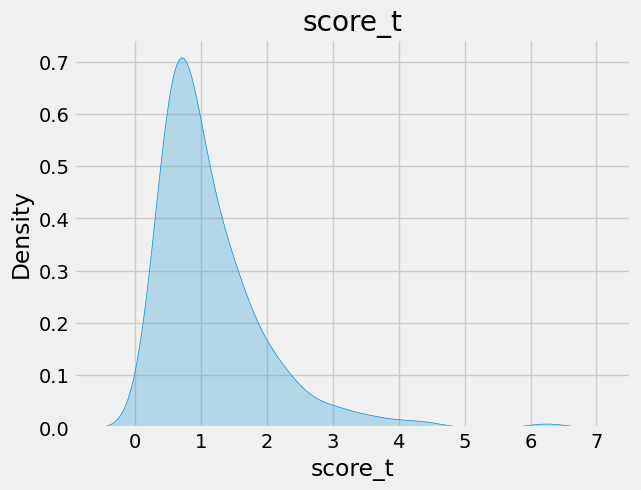

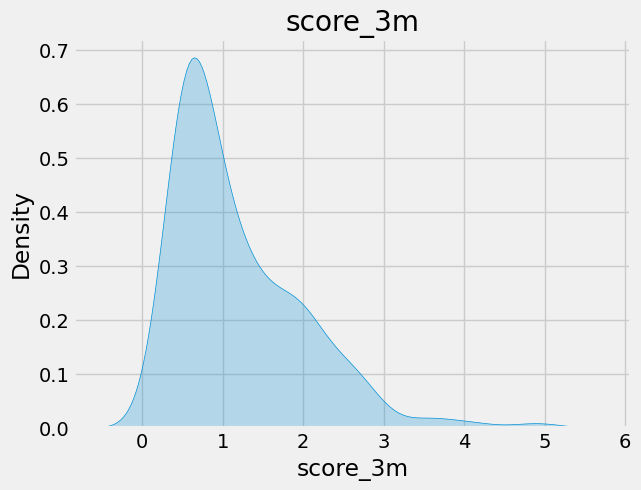

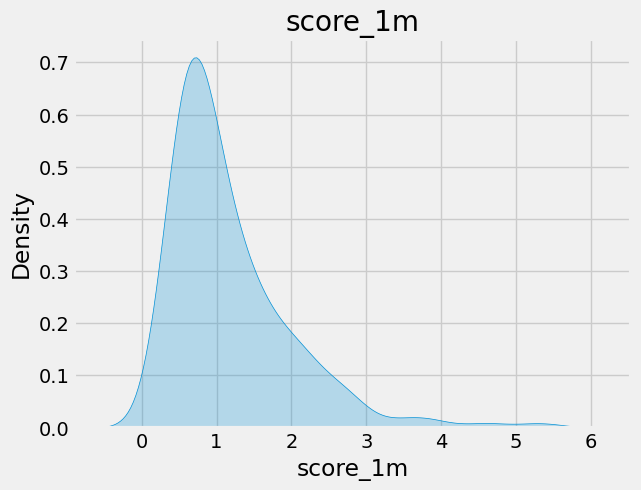

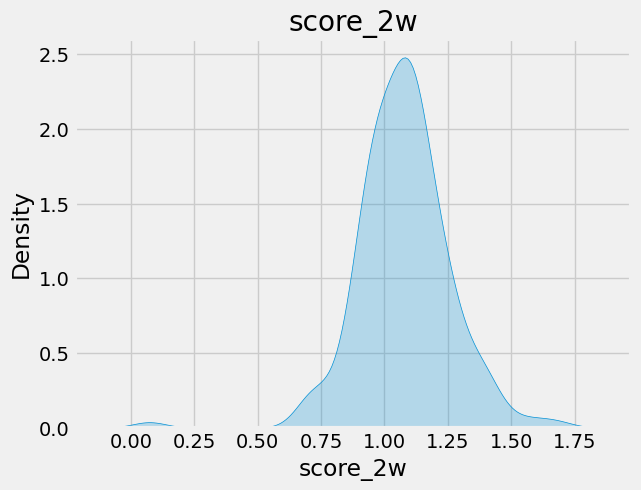

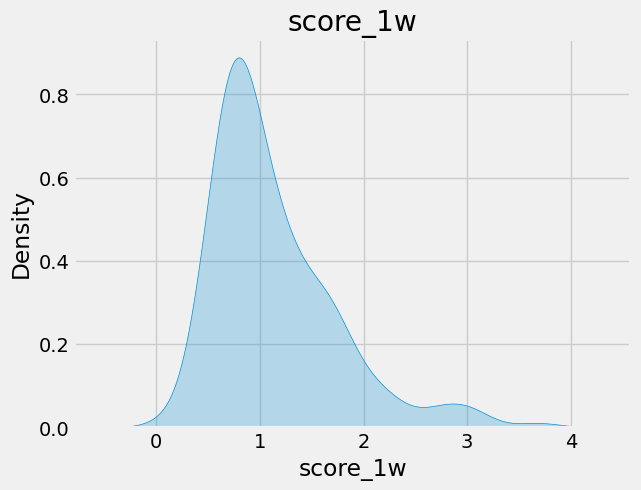

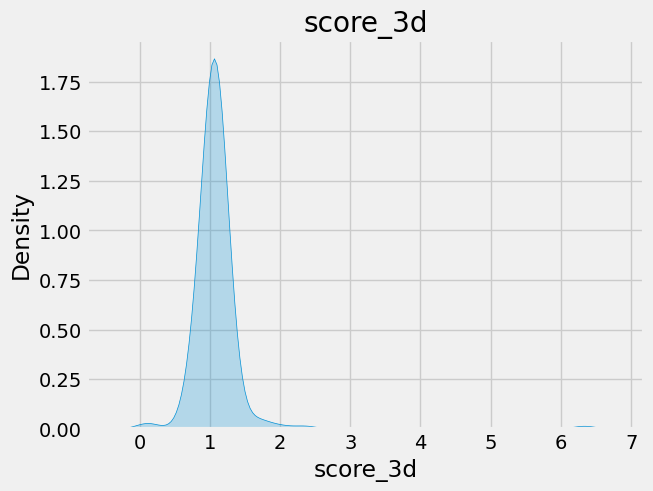

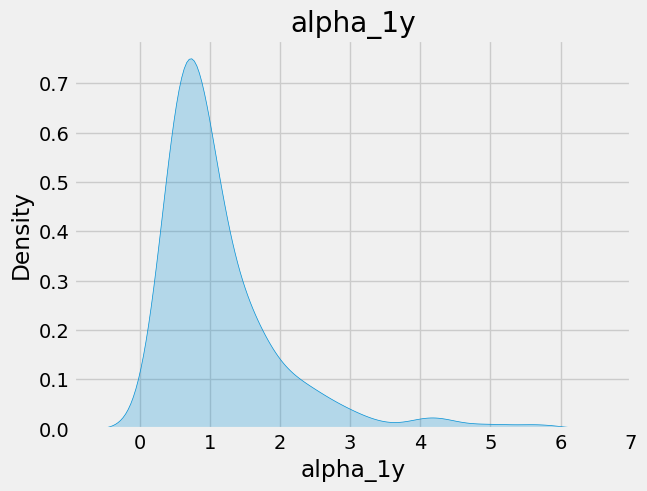

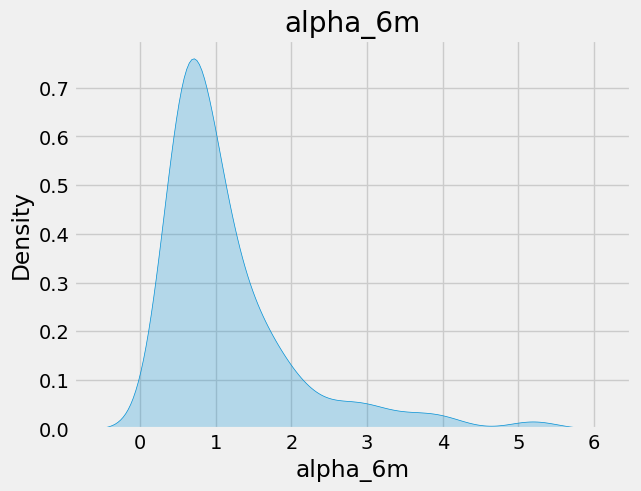

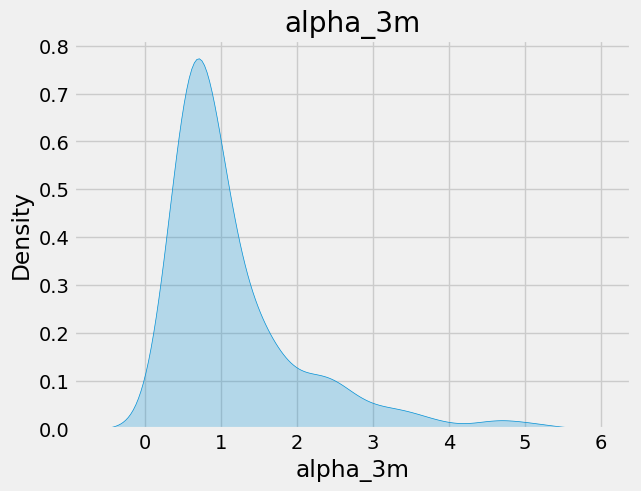

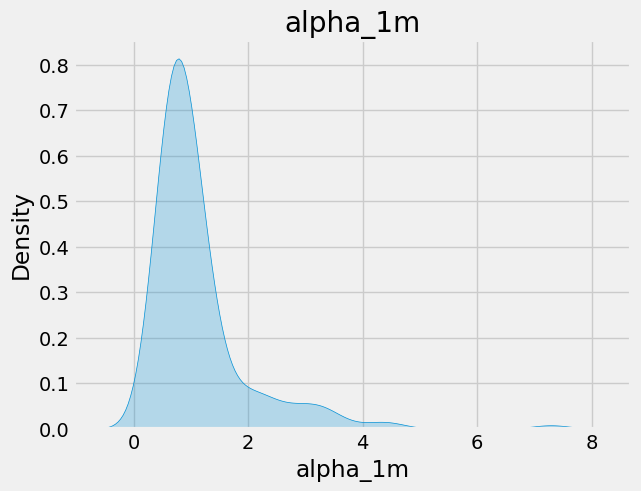

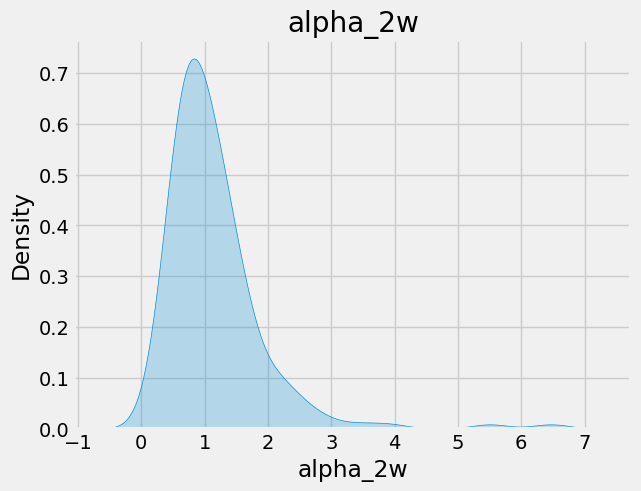

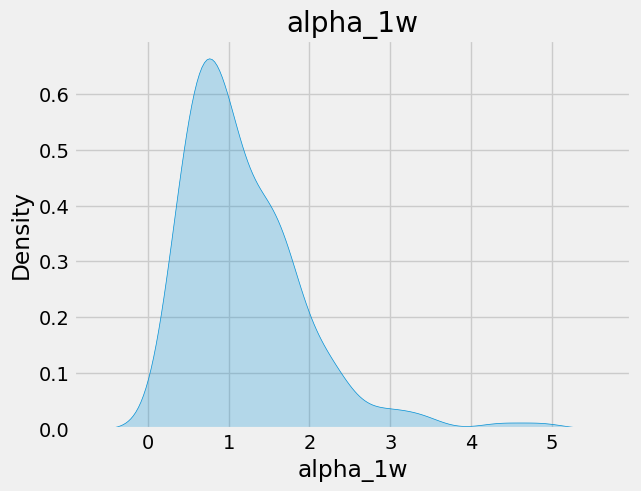

In [94]:
# Plot normal distribution for each moment score and alpha score
import seaborn as sns
import matplotlib.pyplot as plt

for column in moment_score_df.columns:
    if moment_score_df[column].dtype == 'float64':
        sns.kdeplot(moment_score_df[column], fill=True)
        plt.title(column)
        plt.show()

for column in alpha_score_df.columns:
    if alpha_score_df[column].dtype == 'float64':
        sns.kdeplot(alpha_score_df[column], fill=True)
        plt.title(column)
        plt.show()

In [95]:
#add column of alpha and moment score to the final score 
final_score_df=pd.concat([moment_score_df,alpha_score_df],axis=1)
print(final_score_df)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
ABSLAMC     1.638894  1.053595  0.875236  0.981373  1.079471  1.094883   
HDFCAMC     2.266368  2.357632  3.393767  1.219844  1.262090  1.113345   
IVC         0.912652  1.655515  1.431155  1.024462  0.792580  1.153922   
NAM-INDIA   2.637225  2.476182  1.445489  1.140156  0.902170  1.086463   
UTIAMC      0.667434  1.254335  1.287563  1.254184  1.160529  1.047315   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  2.270330  2.272348  1.738762  1.133478  2.164877  1.302134   
NUVAMA      0.830588  0.849113  0.458573  0.916475  0.676894  1.049256   
ONELIFECAP  0.727372  0.552359  0.317892  0.950314  0.722252  0.990391   
SHAREINDIA  1.760685  2.144802  0.944401  0.997615  0.725978  1.045361   
SMCGLOBAL   1.443554  1.682317  0.465842  1.047151  0.876600  1.086444   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  
ABSLAMC     0.561654  0.829040  0.8061

In [96]:
#calulate final moment score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_moment_score']=0.3*final_score_df['score_1m']+0.5*final_score_df['score_3m']+0.2*final_score_df['score_t']


#calulate final alpha score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_alpha_score']=0.3*final_score_df['alpha_1m']+0.5*final_score_df['alpha_3m']+0.2*final_score_df['alpha_6m']

#compute final score as 0.5 to final moment score and 0.5 to final alpha score
final_score_df['final_score']=0.5*final_score_df['final_moment_score']+0.5*final_score_df['final_alpha_score']

#sort the final score in descending order
final_score_df.sort_values(by='final_score',ascending=False,inplace=True)
print(final_score_df)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
SUVIDHAA    3.032248  4.901976  4.605223  1.022087  0.097174  0.730779   
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
IIFLSEC     3.530932  2.800291  2.375724  1.092854  1.401729  1.084267   
...              ...       ...       ...       ...       ...       ...   
FEDFINA     0.458461  0.441454  0.625347       NaN  0.693738  1.057635   
MANCREDIT        NaN       NaN       NaN       NaN       NaN       NaN   
UYFINCORP        NaN       NaN       NaN       NaN       NaN       NaN   
CAPITALSFB       NaN       NaN       NaN       NaN       NaN       NaN   
JSFB             NaN       NaN       NaN       NaN       NaN       NaN   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  \
SUVIDHAA    1.667827  3.617730  5.129

In [97]:
#select top 20 stocks
final_list=final_score_df.head(30)

#print the columns of beta_score_df
print(beta_score_df.columns)

#add expected return of three months and expected return of six months to the final list
final_list['expected_return_1m']=beta_score_df.loc[final_list.index,'expected_return_1m']
final_list['expected_return_3m']=beta_score_df.loc[final_list.index,'expected_return_3m']
final_list['expected_return_6m']=beta_score_df.loc[final_list.index,'expected_return_6m']

#add risk to the final list
final_list['risk']=beta_score_df.loc[final_list.index,'risk']

#change 6m to 1m return using compounding  
final_list['expected_return_6m']=((1+final_list['expected_return_6m'])**(1/6))-1
#change 3m to 1m return using compounding
final_list['expected_return_3m']=((1+final_list['expected_return_3m'])**(1/3))-1
#calculate the weighted expected return for 1m,3m and 6m
final_list['weighted_expected_return']=0.3*final_list['expected_return_1m']+0.5*final_list['expected_return_3m']+0.2*final_list['expected_return_6m']
# print(final_list)

#remove stocks with negative expected return
final_list=final_list[final_list['weighted_expected_return']>0]
print(final_list)

Index(['beta_1y', 'beta_6m', 'beta_3m', 'beta_1m', 'beta_2w', 'beta_1w',
       'stock_return_1y', 'stock_return_6m', 'stock_return_3m',
       'stock_return_1m', 'stock_return_2w', 'stock_return_1w',
       'expected_return_1y', 'expected_return_6m', 'expected_return_3m',
       'expected_return_1m', 'expected_return_2w', 'expected_return_1w',
       'risk', 'alpha_1y', 'alpha_6m', 'alpha_3m', 'alpha_1m', 'alpha_2w',
       'alpha_1w'],
      dtype='object')
             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
SUVIDHAA    3.032248  4.901976  4.605223  1.022087  0.097174  0.730779   
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
PFC         3.598418  3.492516  0.931012  1.083594  1.546999  1.092268   
INVENTURE   1.5945

C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2632348788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_list['expected_return_1m']=beta_score_df.loc[final_list.index,'expected_return_1m']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2632348788.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_list['expected_return_3m']=beta_score_df.loc[final_list.index,'expected_return_3m']
C:\Users\imvar\AppData\Local\Temp\ipykernel_24540\2632348788.py:10: SettingWithCopyWarning: 
A value is tr

In [98]:
#change 6m to 1m return using compounding  
final_list['expected_return_6m']=((1+final_list['expected_return_6m'])**(1/6))-1
#change 3m to 1m return using compounding
final_list['expected_return_3m']=((1+final_list['expected_return_3m'])**(1/3))-1
#calculate the weighted expected return for 1m,3m and 6m
final_list['weighted_expected_return']=0.3*final_list['expected_return_1m']+0.5*final_list['expected_return_3m']+0.2*final_list['expected_return_6m']
# print(final_list)

#remove stocks with negative expected return
final_list=final_list[final_list['weighted_expected_return']>0]
print(final_list)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
PFC         3.598418  3.492516  0.931012  1.083594  1.546999  1.092268   
INVENTURE   1.594507  2.061294  2.245612  1.255725  1.872404  1.143384   
RECLTD      4.428266  2.833205  1.109097  1.106308  1.520537  1.067919   
GEOJITFSL   2.189269  2.618695  1.996318  1.084733  1.421331  1.090989   
AGSTRA      1.942624  2.670974  1.306335  1.254919  1.719145  1.203845   
PAISALO     2.703666  2.574174  1.725969  1.208143  1.795537  1.131627   
SPANDANA    1.963811  2.617002  2.458473  1.333405  1.756154  1.191545   
MAXIND      0.820569  2.118414  2.875211  1.241239  0.932846  1.008936   
THEINVEST   1.515183  1.931598  2.6881

In [99]:
#sort the final list by name of the stock
final_list.sort_index(inplace=True)
print(final_list)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
AGSTRA      1.942624  2.670974  1.306335  1.254919  1.719145  1.203845   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
CENTRUM     1.497651  2.015435  1.875701  1.234578  1.777821  1.229775   
DCBBANK     1.057075  2.084503  2.815587  1.510155  2.815738  1.421689   
GEOJITFSL   2.189269  2.618695  1.996318  1.084733  1.421331  1.090989   
HDFCAMC     2.266368  2.357632  3.393767  1.219844  1.262090  1.113345   
IFCI        2.383720  1.397693  1.209118  1.296282  2.696248  1.216514   
INVENTURE   1.594507  2.061294  2.245612  1.255725  1.872404  1.143384   
MAXIND      0.820569  2.118414  2.875211  1.241239  0.932846  1.008936   
MCX         3.153476  2.894274  0.487545  1.014708  0.721516  1.068259   
MOTILALOFS  2.270330  2.272348  1.7387

In [100]:
portfolio=pd.DataFrame()
for index, row in final_list.iterrows():
    # print(index)
    instrument_token = getInstrumentToken(index)
    # print(instrument_token)

    #get last one month data for each stock
    to_date = '2024-10-08'
    to_date = datetime.strptime(to_date, '%Y-%m-%d')
    from_date = to_date - timedelta(days=90)
    from_date = from_date.strftime('%Y-%m-%d')
    # print(from_date, to_date)
    data = kite.historical_data(instrument_token, from_date, to_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    data['pct_change'] = data['close'].pct_change()
    data = data[['date', 'pct_change']]
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    # print(data)

    #push the data to portfolio
    portfolio[index] = data['pct_change']
#remove the first row of the portfolio
portfolio = portfolio.iloc[1:]
display(portfolio)
    

,5PAISA,AGSTRA,ANANDRATHI,ANGELONE,CENTRUM,DCBBANK,GEOJITFSL,HDFCAMC,IFCI,INVENTURE,...,NAM-INDIA,NIACL,PAISALO,PFC,RECLTD,SPANDANA,THEINVEST,TIMESGTY,VIJIFIN,YESBANK
date,,,,,,,,,,,,,,,,,,,,,
2024-07-11 00:00:00+05:30,0.003425,0.007449,0.005085,-0.004211,-0.004309,0.007868,0.042600,0.005241,0.007955,0.000000,...,-0.002174,0.038753,0.085249,0.017475,0.025323,-0.011610,0.049956,0.013925,-0.023102,0.034856
2024-07-12 00:00:00+05:30,0.002108,0.018047,-0.035206,0.014812,-0.009165,-0.011260,0.005293,-0.002989,0.120470,-0.022388,...,-0.003681,0.004289,-0.010465,-0.027077,-0.013085,0.012227,-0.042386,-0.012526,-0.020270,-0.008904
2024-07-15 00:00:00+05:30,0.006812,0.018835,-0.022363,0.015019,0.020041,0.043957,0.152574,0.006584,0.087394,0.000000,...,0.012214,-0.008506,-0.032238,0.005134,-0.005648,-0.006786,-0.016543,0.027740,-0.020690,0.030469
2024-07-16 00:00:00+05:30,-0.000896,0.012566,-0.000026,-0.025795,-0.007305,-0.020726,-0.032067,-0.025867,-0.020225,0.099237,...,-0.013184,0.015162,-0.025016,-0.015143,-0.025325,-0.002118,0.006740,0.040672,-0.021127,-0.007202
2024-07-18 00:00:00+05:30,-0.027089,-0.047017,-0.010599,-0.027042,-0.051764,0.005941,-0.010382,0.018261,-0.036427,-0.010417,...,-0.015851,-0.032699,0.014855,-0.003548,-0.012385,-0.006779,-0.016100,-0.078951,-0.021583,-0.016800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01 00:00:00+05:30,0.020615,0.019533,-0.010674,0.014990,-0.007210,-0.012223,0.082931,0.015282,-0.015129,0.004310,...,0.051723,0.006292,0.004111,0.012396,0.004148,0.001880,0.007264,0.099850,0.003597,-0.002669
2024-10-03 00:00:00+05:30,-0.026749,-0.059352,0.007287,0.054633,-0.038827,-0.020294,-0.017949,-0.031924,-0.047926,-0.012876,...,-0.038234,-0.026304,-0.030298,-0.053734,-0.034303,-0.027205,-0.028170,-0.046686,-0.025090,-0.024978
2024-10-04 00:00:00+05:30,-0.019445,0.007244,-0.000332,-0.029338,-0.004940,0.001095,0.006769,-0.001467,-0.007744,0.000000,...,0.000303,-0.027281,-0.022125,-0.008983,-0.025386,-0.000614,-0.010459,-0.012421,0.003676,0.004117


In [147]:
#caluculate the correlation for portfolio
covariance = portfolio.cov()
covariance=covariance*252
print(covariance)

#get list of weighted returns for each stock
weighted_returns = final_list[['weighted_expected_return']]
#compond it with 12 to get annual returns
weighted_returns = ((1+weighted_returns)**12)-1
print(weighted_returns)

AttributeError: 'dict' object has no attribute 'cov'

In [148]:
portfolio_returns = []
portfolio_volatility = []

sharpe_ratio = []   

stock_weights = []  
num_assets = len(final_list)
num_portfolios = 100000

np.random.seed(5)
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    stock_weights.append(weights)
    returns = np.dot(weights, weighted_returns['weighted_expected_return'])
    portfolio_returns.append(returns)
    portfolio_risk=np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    portfolio_volatility.append(portfolio_risk)

    #sharpe ratio
    sharpe = (returns-0.07)/portfolio_risk
    sharpe_ratio.append(sharpe)

In [153]:
# Storing the portfolio values
portfolio = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(final_list.index):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

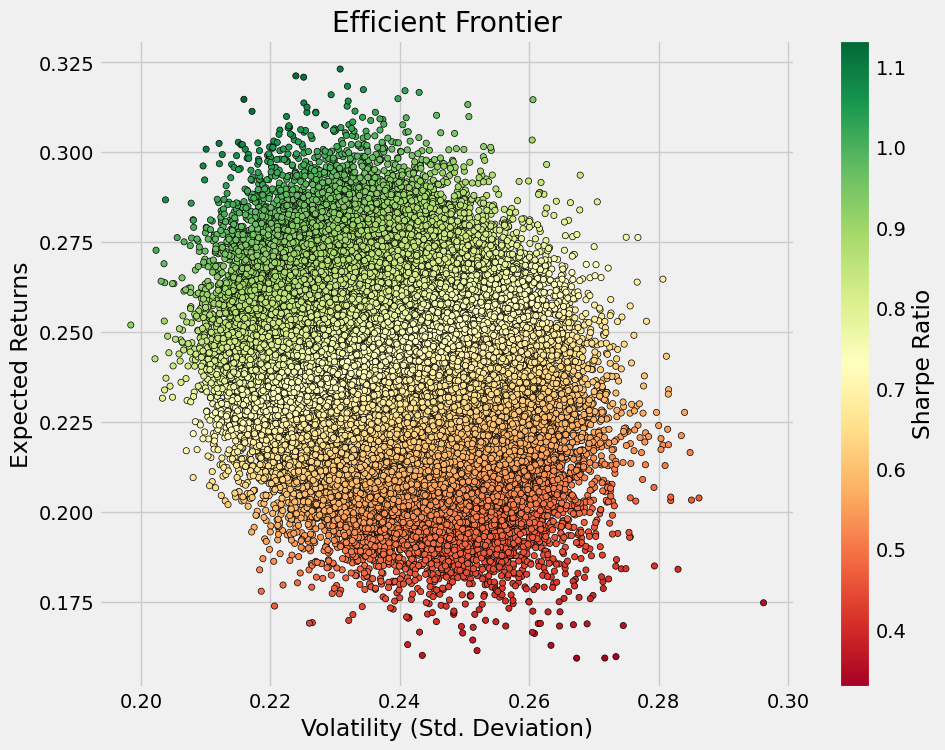

In [154]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

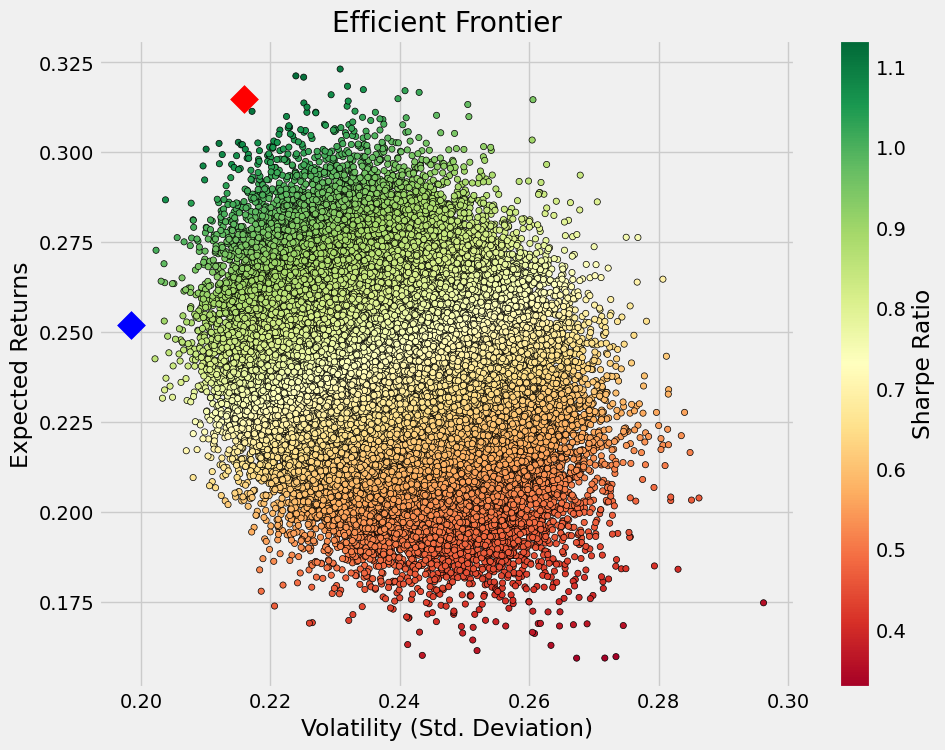

In [155]:
# Finding the Optimal Portfolio
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [156]:
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

                   Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                                0.251940                  0.314704
Volatility                             0.198434                  0.215910
Sharpe Ratio                           0.916879                  1.133361
5PAISA Weight                          0.089989                  0.109376
AGSTRA Weight                          0.002279                  0.006666
ANANDRATHI Weight                      0.081076                  0.094844
ANGELONE Weight                        0.016035                  0.024741
CENTRUM Weight                         0.066547                  0.038409
DCBBANK Weight                         0.083578                  0.027471
GEOJITFSL Weight                       0.007244                  0.001974
HDFCAMC Weight                         0.090018                  0.084377
IFCI Weight                            0.029271                  0.007690
INVENTURE Weight                      